<a href="https://colab.research.google.com/github/cabb1808/miniproyecto1/blob/main/miniproyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Descargar datos de GIT
!wget 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'


--2023-03-23 19:09:27--  https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.02s   

2023-03-23 19:09:28 (61.4 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [2]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.6 MB/s eta 0:00:00


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc
from ipywidgets import interact

In [31]:
ruta_Sismo = 'https://drive.google.com/file/d/1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI/view?usp=sharing'
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisLoc.mat' # sismo regional
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisReg.mat' # sismo regional
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisTele.mat' # sismo regional

Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisLoc.mat
100% 1.55M/1.55M [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisReg.mat
100% 1.55M/1.55M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisTele.mat
100% 1.55M/1.55M [00:00<00:00, 23.1MB/s]


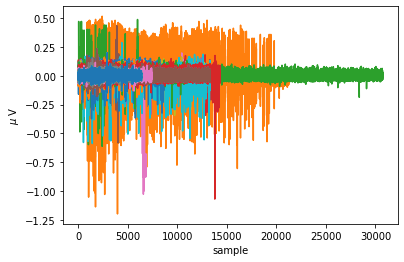

In [32]:
data_local = sc.loadmat('sisLoc.mat')
data_regio = sc.loadmat('sisReg.mat')
data_tele = sc.loadmat('sisTele.mat')

data_local.keys() # variables del diccionario

Y = data_local['Y']
fs = data_local['fs'][0][0]


#Eliminar valores en cero
Y_L=[]
for i in range(len(Y)):
  if Y[i][-1] == 0:
    c=0
    for j in range(1,len(Y[i])):
      if Y[i][-j] != 0:
        break
      else: 
        c=c+1
    Y_L.append(Y[i][0:(len(Y[i])-c)])
  else: 
    Y_L.append(Y[i][:])

#eliminamos media y graficamos

for i in range(len(Y_L)):
  Y_L[i]=Y_L[i]-np.mean(Y_L[i])
  plt.plot(Y_L[i].T)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

In [39]:
@interact(idx = (0,20,1))

def plotSismos(idx):
  
  sampleSignal = Y_L[idx][:] # se extrae una señal de la base de datos
  plt.figure
  plt.plot(sampleSignal)
  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

interactive(children=(IntSlider(value=10, description='idx', max=20), Output()), _dom_classes=('widget-interac…

In [40]:
# Agregar filtro
from scipy.signal import butter, lfilter, freqz


#definimos filtro
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y




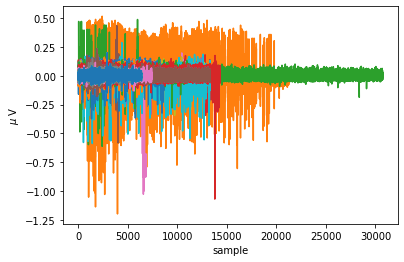

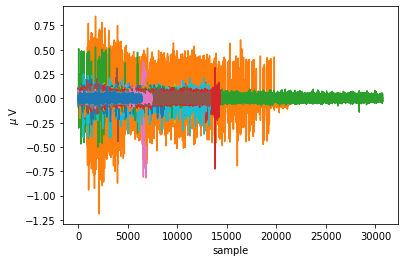

In [41]:
order = 4     
fs=110
cutoff = 50
Y_Lfilt=[]

for i in range(len(Y_L)):
  Y_Lfilt.append(butter_lowpass_filter(Y_L[i], cutoff, fs, order))

for i in range(len(Y_L)):
  plt.plot(Y_L[i].T)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

for i in range(len(Y_L)):
  plt.plot(Y_Lfilt[i].T)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

aca definimos que se puede usar filtro pasabajas o pasabandas, pero elegimos pasabajas porque se ajusta mas al rango deseado de 0-50

para una biografia si es necesario https://www.delftstack.com/es/howto/python/low-pass-filter-python/

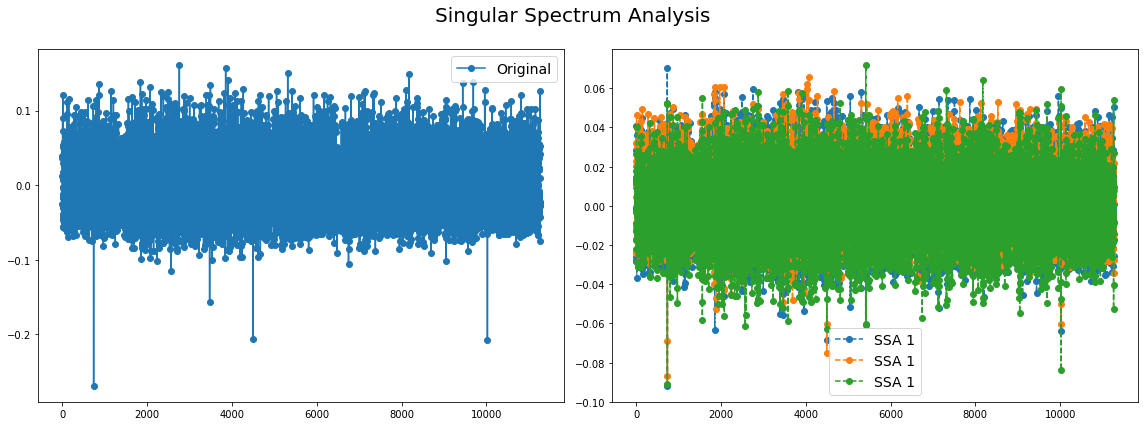

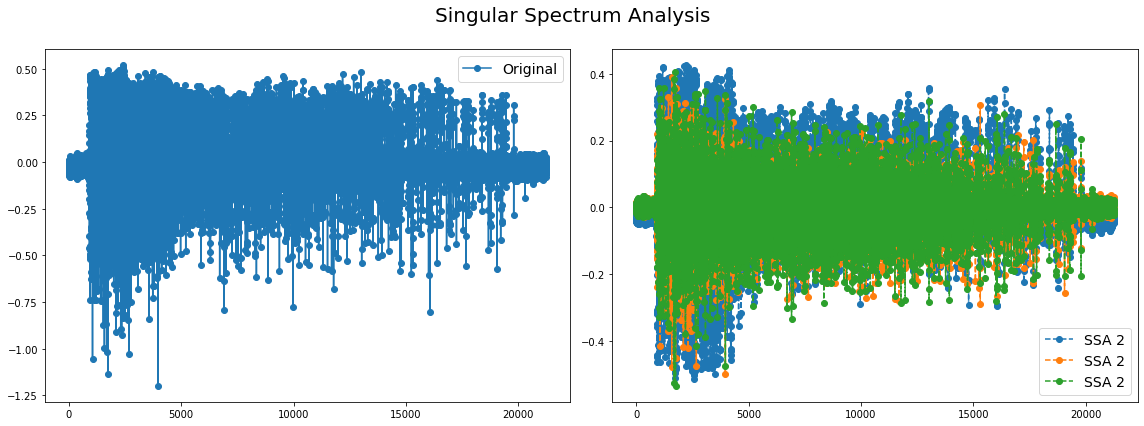

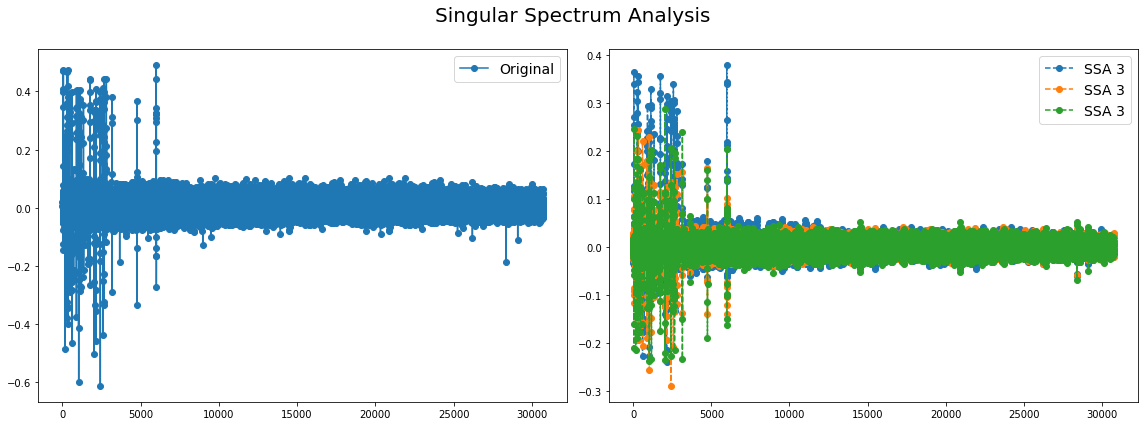

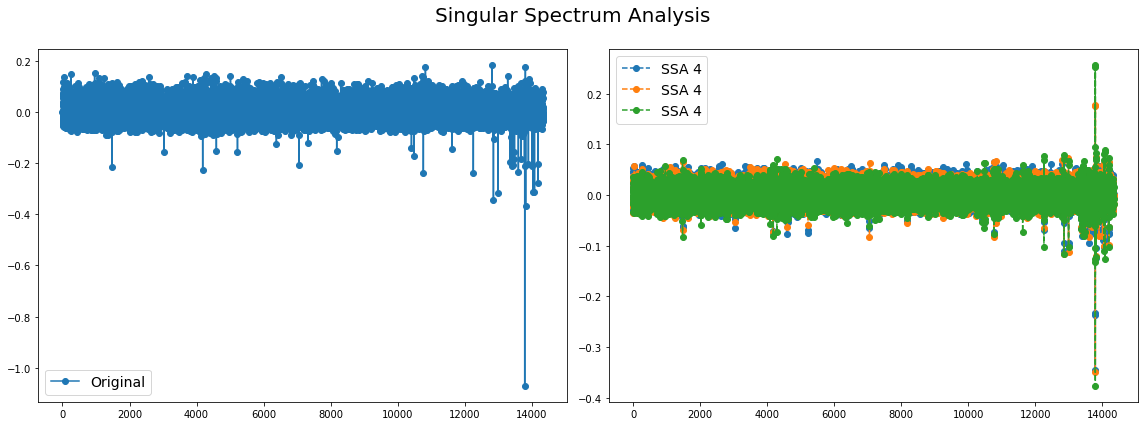

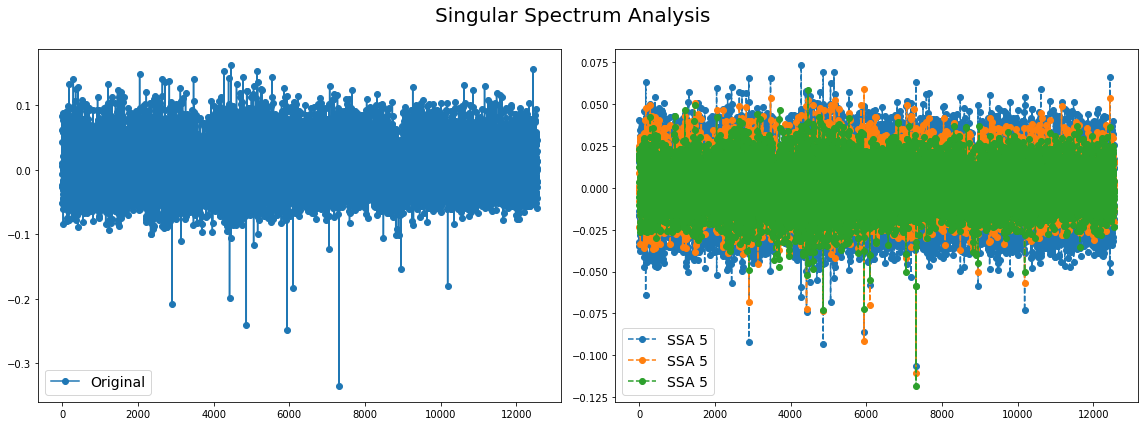

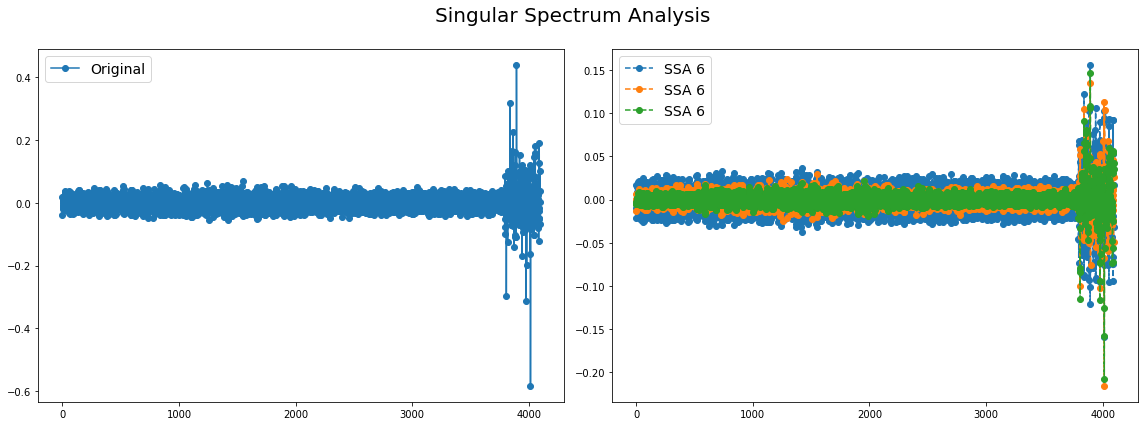

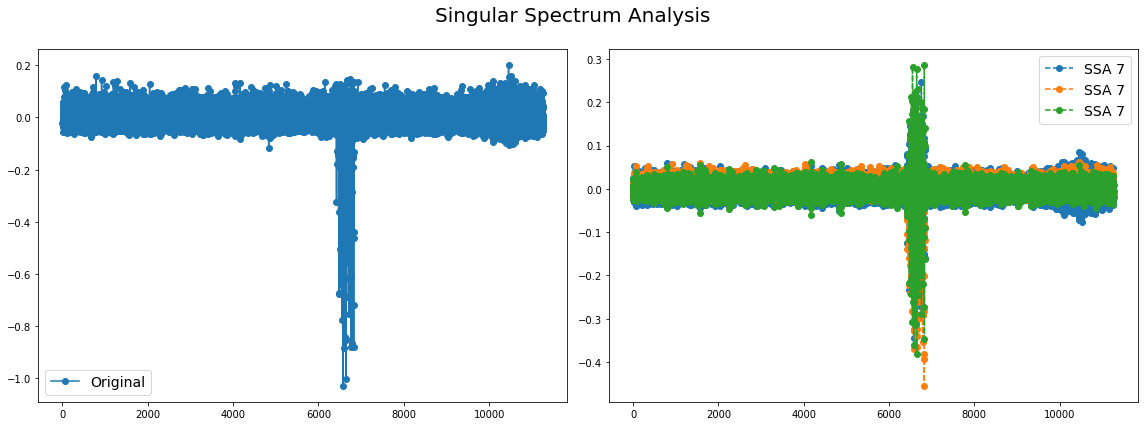

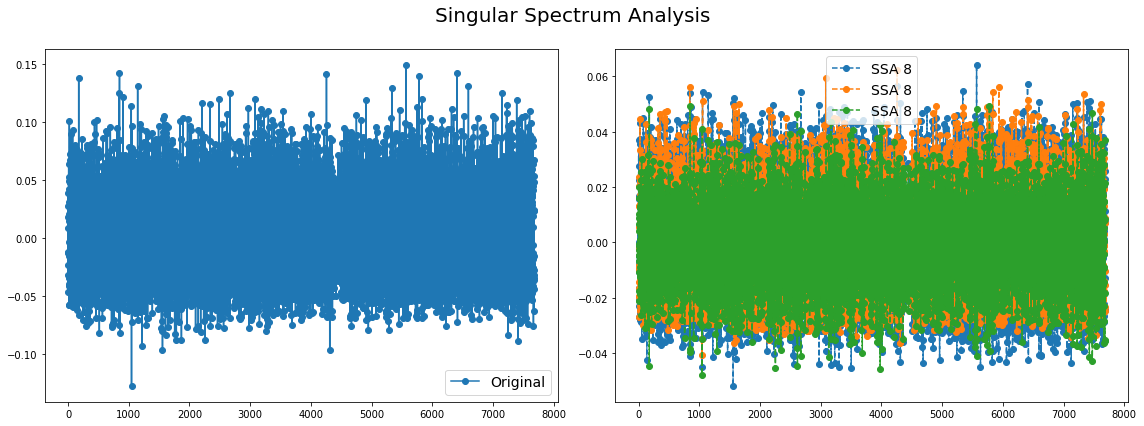

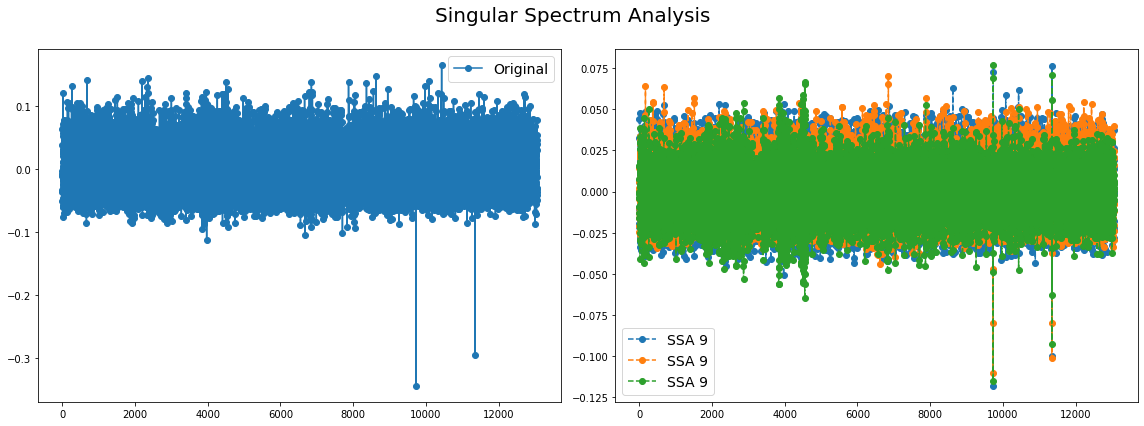

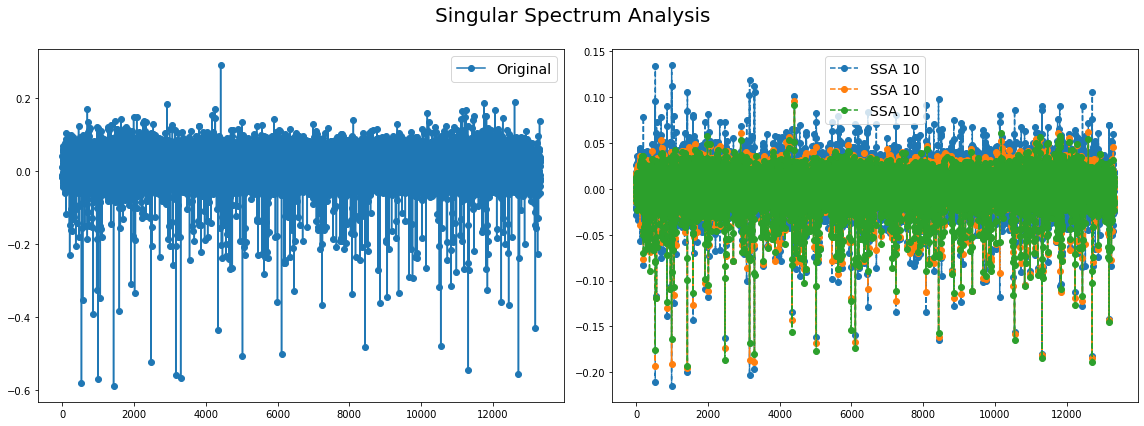

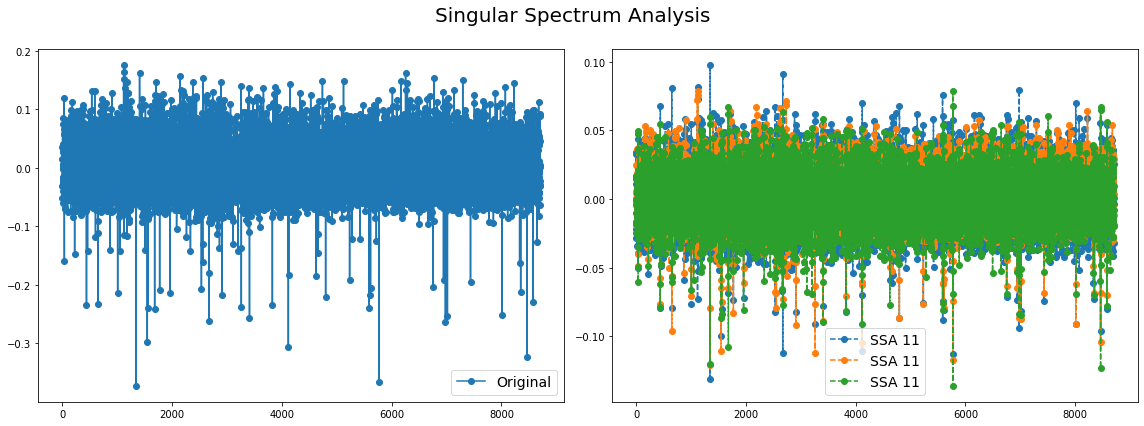

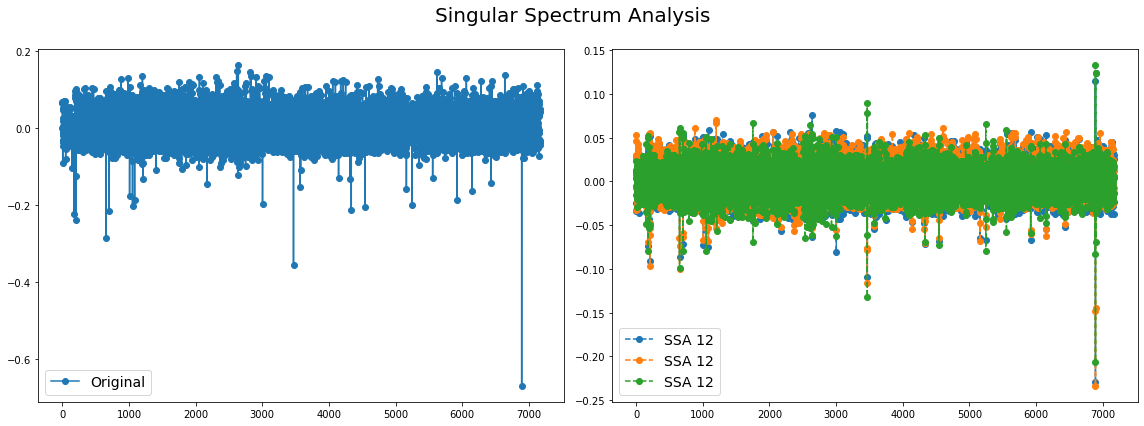

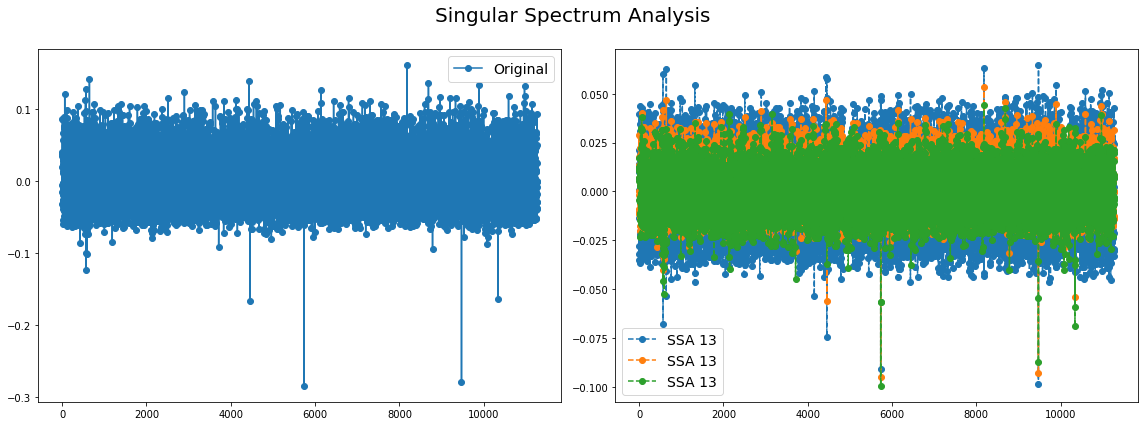

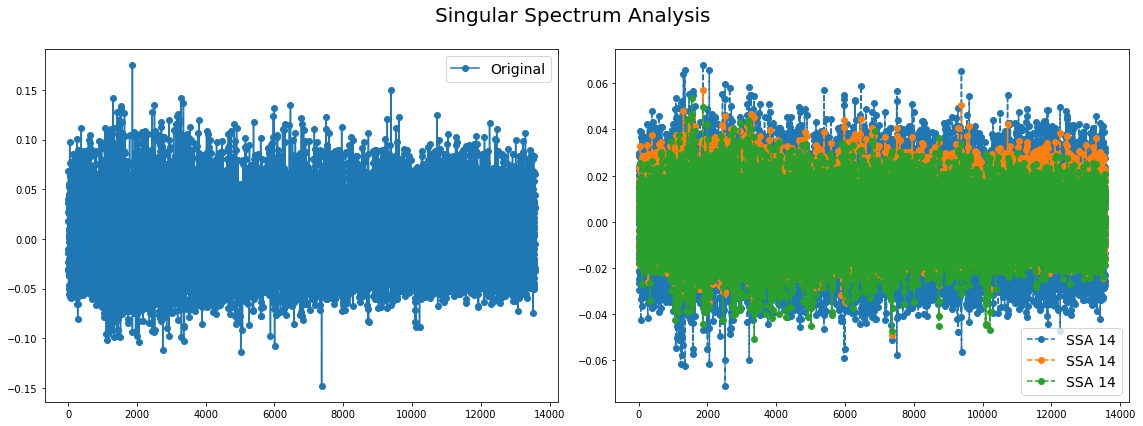

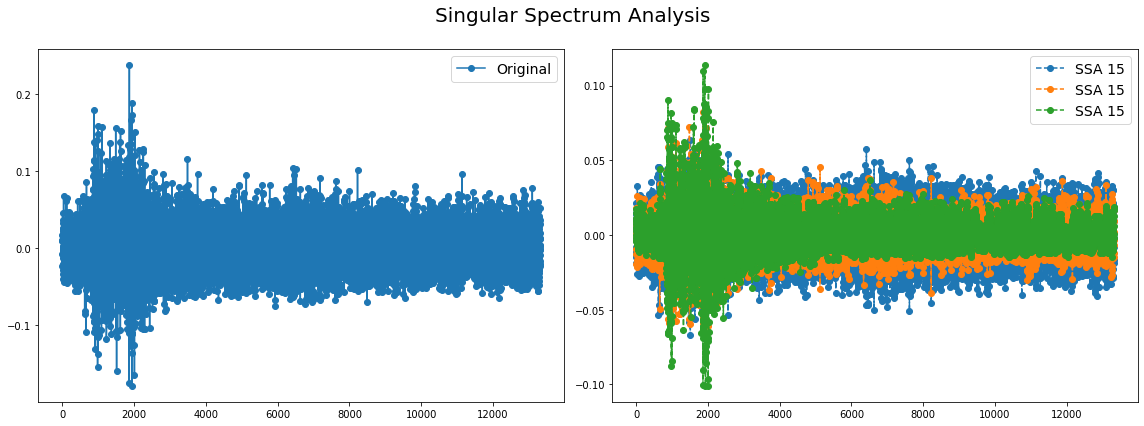

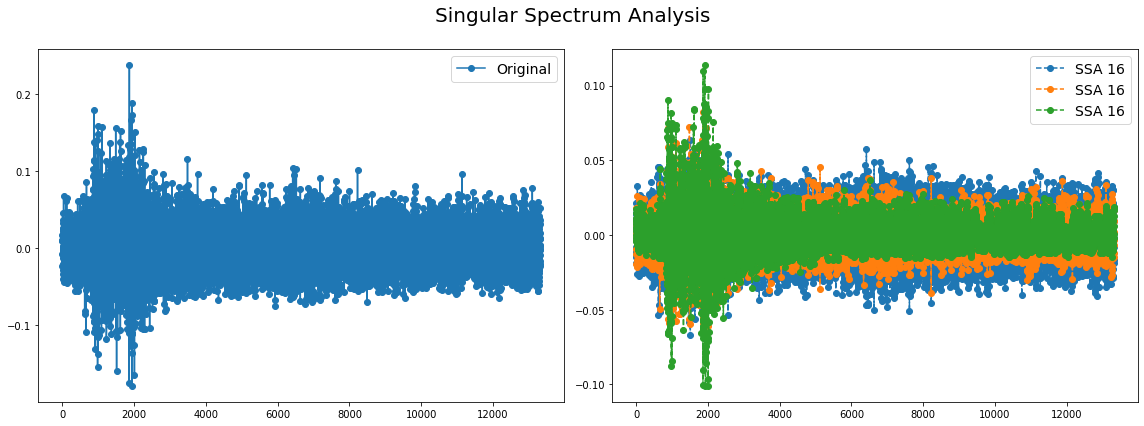

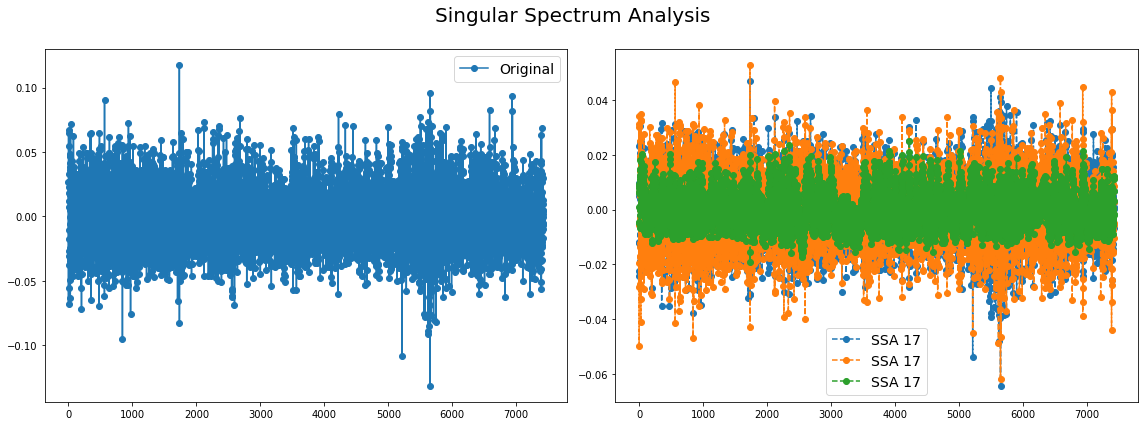

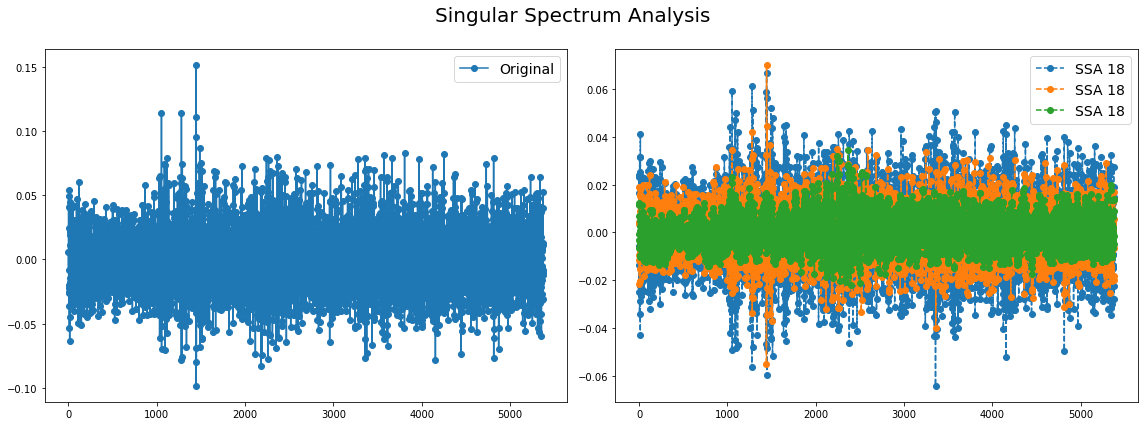

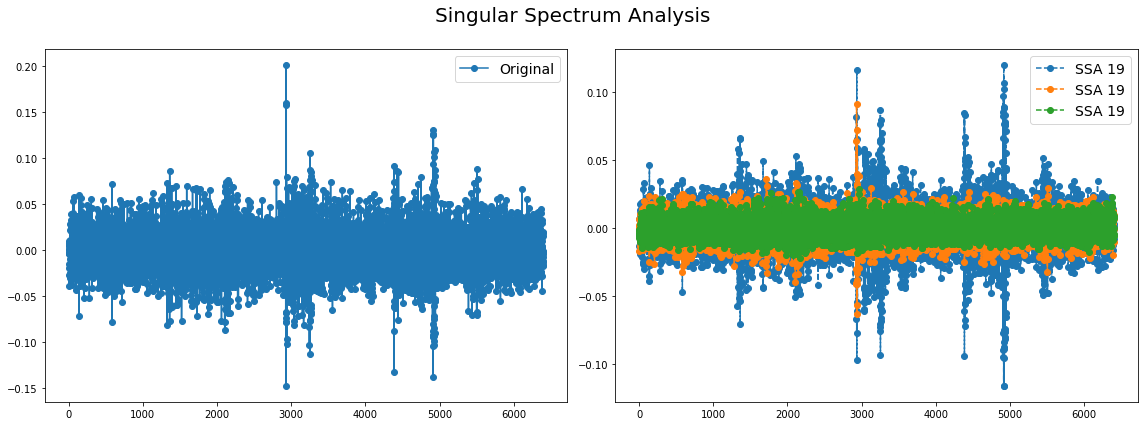

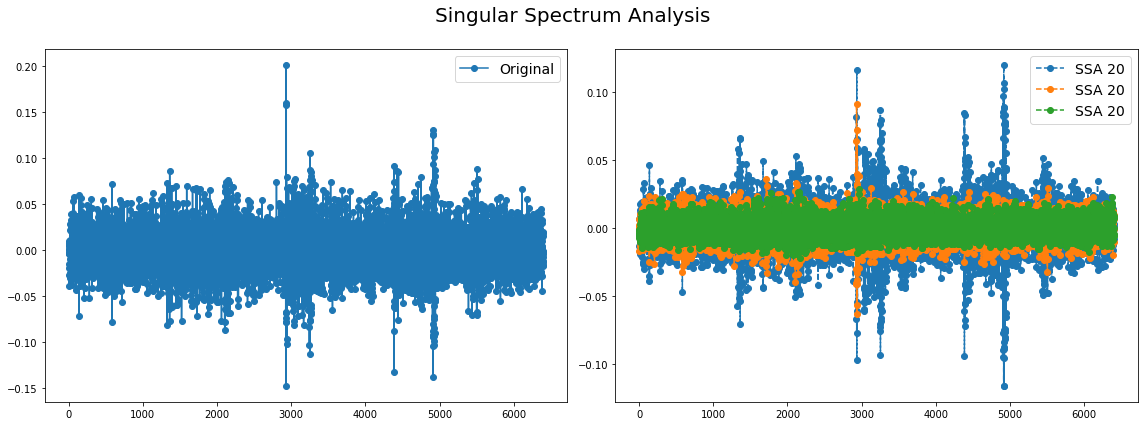

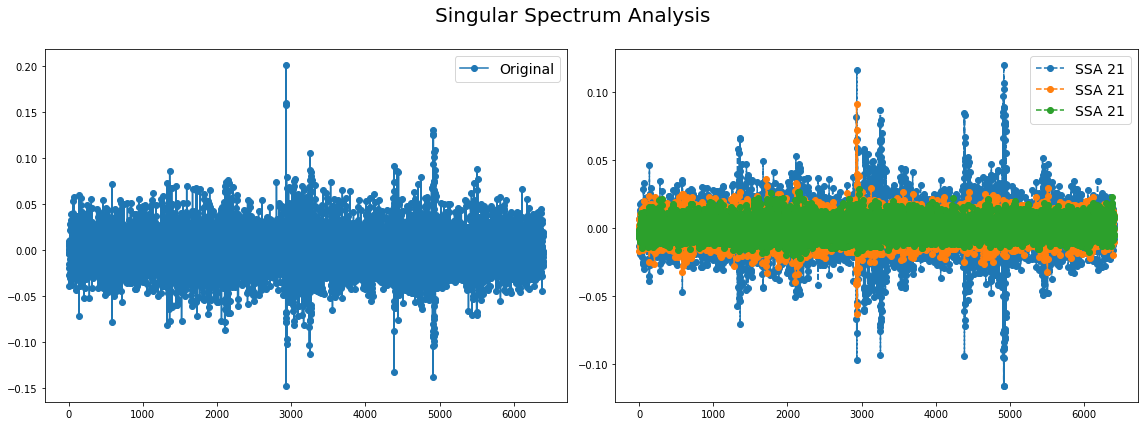

In [66]:
# We decompose the time series into three subseries
X_L = Y_L # Conjunto de 21 sismos
for i in range(21):
  X_L[i] = np.array(X_L[i])
  
groups = 3

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=groups)
X_ssa = []  # initialize X_ssa

for i in range(21):
  X_L_i = X_L[i].reshape(1,-1)  # use the i-th subseries
  X_ssa_i = ssa.fit_transform(X_L_i)
  X_ssa.append(X_ssa_i)

  # Show the results for the first time series and its subseries
  plt.figure(figsize=(16, 6))
  idSignal = 3
  ax1 = plt.subplot(121)
  ax1.plot(X_L[i], 'o-', label='Original')
  ax1.legend(loc='best', fontsize=14)

  ax2 = plt.subplot(122)

  for j in range(groups):
    ax2.plot(X_ssa[i][j], 'o--', label='SSA {0}'.format(i + 1))
  ax2.legend(loc='best', fontsize=14)

  plt.suptitle('Singular Spectrum Analysis', fontsize=20)

  plt.tight_layout()
  plt.subplots_adjust(top=0.88)
  plt.show()

# The first subseries consists of the trend of the original time series.
# The second and third subseries consist of noise.

Caracteristicas

In [ ]:
f_L=[]
t_L=[]
Zxx_L=[]

for i in range(21):
  for j in range(3):
    